In [122]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

import os
import pandas as pd

from PIL import Image

In [123]:
torch.cuda.is_available()

True

In [124]:
# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [125]:
class CustomImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform)
        # Create a mapping from folder names to indices
        self.custom_class_to_idx = {name: int(name) for name in self.classes}
        # Create a reverse mapping
        self.custom_idx_to_class = {v: k for k, v in self.custom_class_to_idx.items()}
        
    def __getitem__(self, index):
        path, _ = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        
        # Use the folder name as the label
        label = int(os.path.basename(os.path.dirname(path)))
        return sample, label

In [126]:
bar_transform = transforms.Compose([
    transforms.Resize((40, 30)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

data_dir = './data/features/numbers'

dataset = CustomImageFolder(root=data_dir, transform=bar_transform)

In [127]:
size = len(dataset)
size

677

In [128]:
train_size = int(0.8 * size)
test_size = size - train_size

In [129]:
train, test = random_split(
    dataset=dataset, lengths=[train_size, test_size]
)

In [130]:
image, label = train[0]
label

7

In [131]:
train_dl = DataLoader(train, batch_size=32, shuffle=True)
test_dl = DataLoader(test, batch_size=32, shuffle=False)

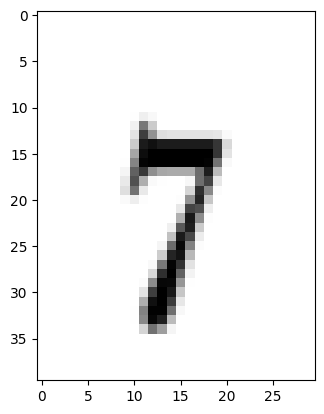

In [132]:
import matplotlib.pyplot as plt
plt.imshow(image.permute(1,2,0).squeeze(), cmap="gray")

In [133]:
image.shape

torch.Size([1, 40, 30])

In [134]:
class_names = train_dl.dataset.dataset.classes
class_names

['0',
 '1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

In [135]:
custom_class_to_idx = train_dl.dataset.dataset.custom_class_to_idx
print(custom_class_to_idx)

{'0': 0, '1': 1, '10': 10, '11': 11, '12': 12, '13': 13, '14': 14, '15': 15, '16': 16, '17': 17, '18': 18, '19': 19, '2': 2, '20': 20, '21': 21, '22': 22, '23': 23, '24': 24, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}


In [136]:
from torch import nn
latten_model = nn.Flatten()

In [137]:
train_features_batch, train_labels_batch = next(iter(train_dl))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 40, 30]), torch.Size([32]))

In [138]:
class NumberCNN(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units*2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units*2, hidden_units*2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units*2 * 7 * 10, output_shape)
        )
    
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

numberCNN = NumberCNN(input_shape=1, hidden_units=32, output_shape=25).to(device)

In [139]:
numberCNN = NumberCNN(
    input_shape=1,
    hidden_units=15,
    output_shape=len(class_names)
).to(device=device)

In [140]:
numberCNN(image.unsqueeze(0).to(device))

tensor([[ 0.0667,  0.0017, -0.0528, -0.0036,  0.0048, -0.0152, -0.0098, -0.0063,
         -0.0072,  0.0148,  0.0057,  0.0352, -0.0031, -0.0837,  0.0277, -0.0235,
         -0.0509, -0.0081, -0.0042,  0.0429, -0.0063, -0.0456, -0.0210,  0.0523,
          0.0603]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [141]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists")
else:
  print("downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)
from helper_functions import accuracy_fn

helper_functions.py already exists


In [142]:
def train_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device = device
):
  train_loss, train_acc = 0, 0
  model.train()
  for batch_idx, (train_features_batch, train_labels_batch) in enumerate(dataloader):
    train_features_batch = train_features_batch.to(device)
    train_labels_batch = train_labels_batch.to(device)
    # forward pass
    y_logits = model(train_features_batch)
    y_pred = torch.argmax(y_logits, dim=1)

    # calculate loss
    loss = loss_fn(y_logits, train_labels_batch)
    train_loss += loss
    train_acc += accuracy_fn(train_labels_batch, y_pred)

    # optimizer zero grad
    optimizer.zero_grad()

    # backprop
    loss.backward()

    # optimizer step
    optimizer.step()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  print(f"train loss: {train_loss:.4f} | train acc: {train_acc:.2f}")

In [143]:
# test loop function
def test_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    device: torch.device = device
):
  """Returns a dict. containing the results of model predicting on data_loader"""
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for batch_idx, (test_features_batch, test_labels_batch) in enumerate(data_loader):
      test_features_batch = test_features_batch.to(device)
      test_labels_batch = test_labels_batch.to(device)
      # forward pass
      y_pred_logits = model(test_features_batch).squeeze()
      test_pred = torch.argmax(y_pred_logits, dim=1)
      # calculate loss
      loss += loss_fn(y_pred_logits, test_labels_batch)
      # calculate acc:
      acc += accuracy_fn(test_labels_batch, test_pred)

    # calculate the test loss avg per batch
    loss /= len(data_loader)
    # calculate the test acc avg per batch
    acc /= len(data_loader)
  print(f"test loss: {loss:.4f} | test acc: {acc:.2f}")

In [144]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=numberCNN.parameters(), lr=0.1)

epochs = 50

for epoch in range(epochs):
    print(f"Epoch: {epoch}\n------")
    train_step(
        model=numberCNN,
        dataloader=train_dl,
        loss_fn=loss_fn,
        optimizer=optimizer
    )
    test_step(
        model=numberCNN,
        data_loader=test_dl,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

Epoch: 0
------
train loss: 3.2226 | train acc: 3.31
test loss: 3.2226 | test acc: 1.88
Epoch: 1
------
train loss: 3.2097 | train acc: 6.49
test loss: 3.2200 | test acc: 4.38
Epoch: 2
------
train loss: 3.1796 | train acc: 8.11
test loss: 3.1679 | test acc: 8.12
Epoch: 3
------
train loss: 2.9683 | train acc: 11.07
test loss: 2.7579 | test acc: 18.75
Epoch: 4
------
train loss: 2.6490 | train acc: 25.32
test loss: 2.4578 | test acc: 27.50
Epoch: 5
------
train loss: 1.7527 | train acc: 48.02
test loss: 1.7580 | test acc: 46.25
Epoch: 6
------
train loss: 1.2835 | train acc: 64.52
test loss: 1.2929 | test acc: 66.88
Epoch: 7
------
train loss: 0.8765 | train acc: 74.77
test loss: 0.8138 | test acc: 76.88
Epoch: 8
------
train loss: 0.5043 | train acc: 86.16
test loss: 1.0393 | test acc: 73.75
Epoch: 9
------
train loss: 0.4816 | train acc: 86.71
test loss: 0.4967 | test acc: 86.25
Epoch: 10
------
train loss: 0.3758 | train acc: 92.08
test loss: 0.5150 | test acc: 86.25
Epoch: 11
-----

Labels: tensor([ 4, 20,  9, 10,  2, 21, 21, 21,  2, 12, 11,  4, 12,  0, 14,  5, 11, 15,
         5, 12,  0,  3,  6,  0,  3,  9, 24, 19,  8, 22, 15,  3])
Image shape: torch.Size([32, 1, 40, 30])


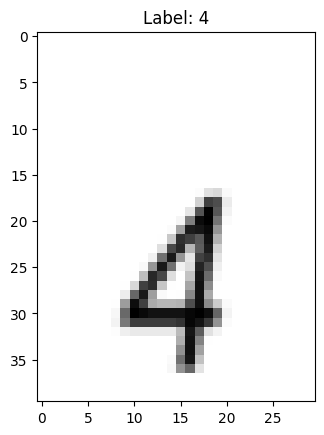

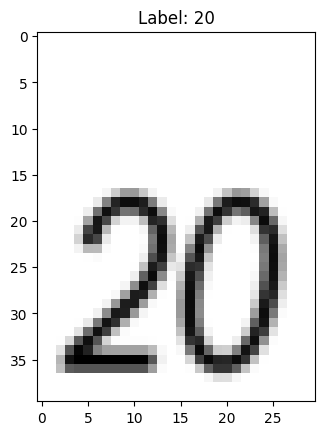

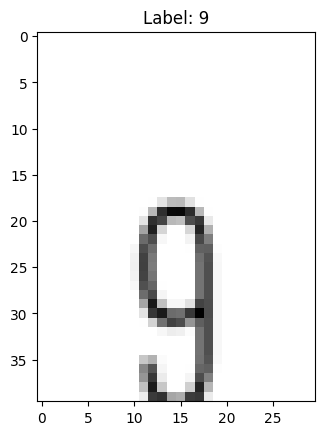

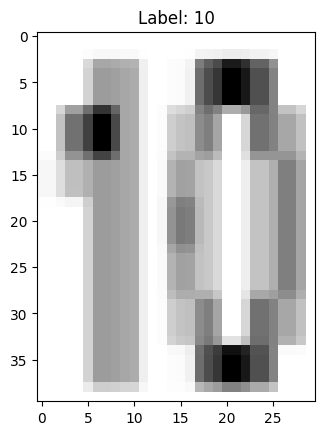

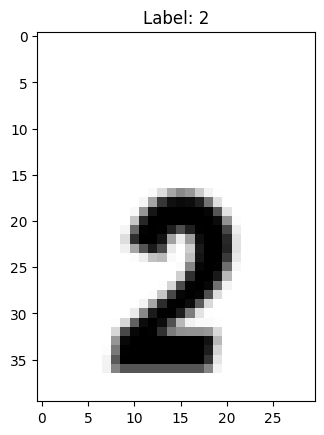

In [145]:
for images, labels in test_dl:
    print("Labels:", labels)
    print("Image shape:", images.shape)
    for i in range(5):  # Print first 5 images
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.show()
    break

In [146]:
# making preds
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module):
  """Returns a dict. containing the results of model predicting on data_loader"""
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for batch_idx, (test_features_batch, test_labels_batch) in enumerate(data_loader):
      test_features_batch = test_features_batch.to(device)
      test_labels_batch = test_labels_batch.to(device)
      # forward pass
      y_pred_logits = model(test_features_batch).squeeze()
      test_pred = torch.softmax(y_pred_logits, dim=1).argmax(dim=1)

      # calculate loss
      loss += loss_fn(y_pred_logits, test_labels_batch)

      # calculate acc:
      acc += accuracy_fn(test_labels_batch, test_pred)

    # calculate the test loss avg per batch
    loss /= len(data_loader)
    # calculate the test acc avg per batch
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc}

In [147]:
model_results = eval_model(
    model=numberCNN,
    data_loader=test_dl,
    loss_fn=loss_fn
)
model_results

{'model_name': 'NumberCNN',
 'model_loss': 0.7147128582000732,
 'model_acc': 93.125}

In [148]:
from pathlib import Path

In [149]:
model_path = Path("./models")
name = "number_model.pth"
model_save_path = model_path / name

In [150]:
torch.save(obj=numberCNN.state_dict(), f=model_save_path)